In [1]:
import csv
from xml.etree import ElementTree
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import StrMethodFormatter
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
from pyclustertend import hopkins, vat, assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale, MinMaxScaler, minmax_scale, RobustScaler,robust_scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [2]:
# the csv containing all the labels
data_file = "C:/Users/aprodea/work/metrics-tax-compare/classification/2_all_labels.csv"
# data_file = "C:/Users/aprodea/work/experiment-projects/sharex/classification/1_all_labels.csv"

var_list = ['LOC', 'CC', 'NP', 'NV', 'NEST', 'Ca', 'Ce', 'NChg', 'NCall']
label_list = ['CLevel_threshold', 'CLevel_k_means', 'CLevel_em']

plots_save_to_location = "C:/Users/aprodea/work/metrics-tax-compare/classification/plots_1"
# plots_save_to_location = "C:/Users/aprodea/work/experiment-projects/sharex/classification/plots_1"

chg_lines_file = "C:/Users/aprodea/work/metrics-tax-compare/research_last-version/merged/change_lines.csv"

# chg_lines_file = "C:/Users/aprodea/work/experiment-projects/sharex/analysis/v12/merged/change_lines.csv"

In [3]:
data = pd.read_csv(data_file, sep=';')
data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0,low,low,high
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0,low,low,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0,low,low,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0,low,low,regular
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0,low,low,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0,low,low,high
751,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0,low,low,low
752,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0,low,low,high
753,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,15.0,4.0,regular,low,high


In [20]:
data['LOC'].sum()

5143.0

In [4]:
scaled_data = data.copy()

for col_name in var_list:
    col = scaled_data[col_name]
    min_col, max_col = col.min(), col.max()
    scaled_data[col_name] = (col - min_col) / (max_col - min_col)
    
scaled_data

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),0.154762,0.029851,0.000000,0.022727,0.1,0.000000,0.025641,0.03125,0.000115,low,low,high
1,GES_GRT.GES_GRTCoreModule.Initialize(),0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000115,low,low,low
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),0.011905,0.000000,0.000000,0.000000,0.0,0.000000,0.012821,0.00000,0.000115,low,low,low
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0.011905,0.000000,0.000000,0.000000,0.0,0.142857,0.000000,0.00000,0.106956,low,low,regular
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0.011905,0.000000,0.000000,0.000000,0.0,0.114286,0.000000,0.00000,0.068034,low,low,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0.083333,0.000000,0.071429,0.000000,0.0,0.028571,0.038462,0.09375,0.000115,low,low,high
751,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000,0.029851,0.142857,0.000000,0.1,0.028571,0.025641,0.00000,0.000231,low,low,low
752,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.000000,0.074627,0.142857,0.000000,0.1,0.028571,0.025641,0.00000,0.000231,low,low,high
753,GES_GRT.Web.App.Startup.AppNavigationProvider....,0.011905,0.000000,0.071429,0.000000,0.0,0.000000,0.012821,0.43750,0.000115,regular,low,high


In [17]:
from sklearn.decomposition import PCA

comp = len(var_list)
pca_ = PCA(n_components=comp, random_state=42)
pca_.fit(scaled_data[var_list])

# by looking at the PC1 (First Principal Component)
# we can conclude which features are the most important (they have higher values)
print('PC 1:', pca_.components_[0])
for i in range(len(pca_.components_[0])):
    print('var ', i, round(pca_.components_[0][i], 6))
print('explained variance: ', pca_.explained_variance_ratio_)

PC 1: [ 0.58353592  0.34964083  0.16293052  0.44941326  0.32465535  0.01114049
  0.38665963  0.23137961 -0.01229221]
var  0 0.583536
var  1 0.349641
var  2 0.162931
var  3 0.449413
var  4 0.324655
var  5 0.01114
var  6 0.38666
var  7 0.23138
var  8 -0.012292
explained variance:  [0.47731921 0.18549684 0.0923015  0.06516634 0.05307879 0.04289868
 0.0390186  0.02733344 0.0173866 ]


In [18]:
print(var_list[0], var_list[3], var_list[6])

LOC NV Ce


In [5]:
melted_data = scaled_data.copy()
melted_data = pd.melt(melted_data, id_vars=['Method', 'CLevel_threshold', 'CLevel_k_means', 'CLevel_em'], value_vars=var_list)
melted_data

,Method,CLevel_threshold,CLevel_k_means,CLevel_em,variable,value
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),low,low,high,LOC,0.154762
1,GES_GRT.GES_GRTCoreModule.Initialize(),low,low,low,LOC,0.000000
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),low,low,low,LOC,0.011905
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,low,low,regular,LOC,0.011905
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),low,low,regular,LOC,0.011905
...,...,...,...,...,...,...
6790,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,low,low,high,NCall,0.000115
6791,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,low,low,low,NCall,0.000231
6792,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,low,low,high,NCall,0.000231
6793,GES_GRT.Web.App.Startup.AppNavigationProvider....,regular,low,high,NCall,0.000115


Threshold clustering


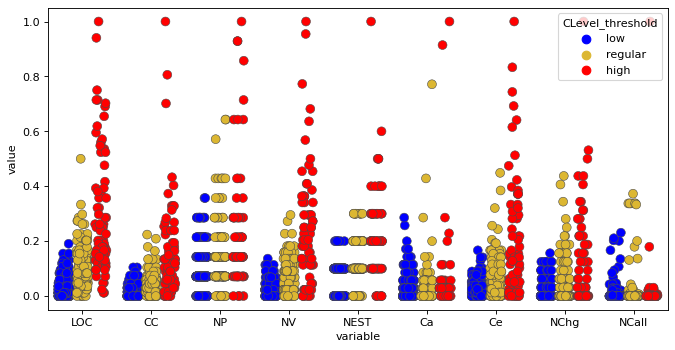

In [6]:
fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
sns.stripplot(data=melted_data, x='variable', y='value', hue='CLevel_threshold',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=8, ax=ax, linewidth=.5, dodge=True)

print("Threshold clustering")
# plt.show()
plt.savefig(plots_save_to_location + '/melted_threshold', bbox_inches = 'tight', pad_inches = 0)

k-means clustering


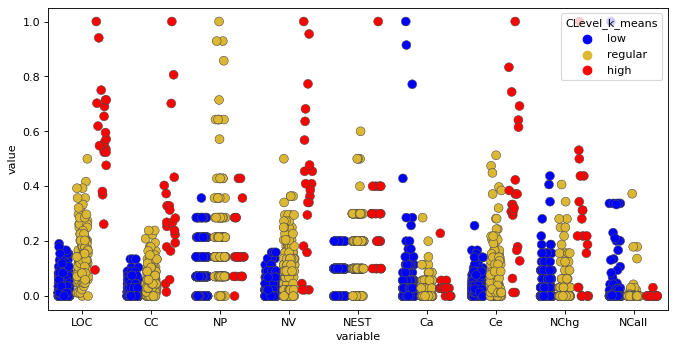

In [7]:
fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
sns.stripplot(data=melted_data, x='variable', y='value', hue='CLevel_k_means',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=8, ax=ax, linewidth=.5, dodge=True)

print("k-means clustering")
# plt.show()
plt.savefig(plots_save_to_location + '/melted_k_means', bbox_inches = 'tight', pad_inches = 0)

EM clustering


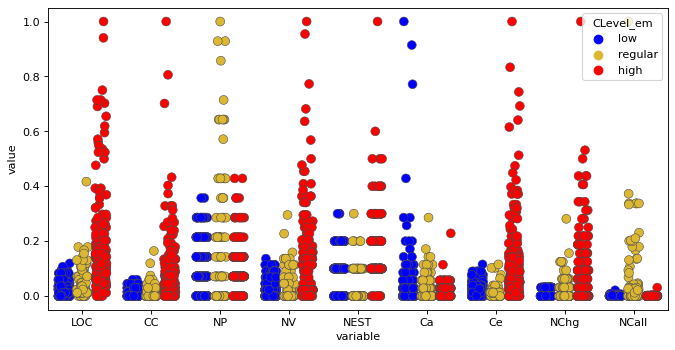

In [8]:
fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
sns.stripplot(data=melted_data, x='variable', y='value', hue='CLevel_em',
              palette={'low':'blue', 'regular':'#DCB732', 'high':'red'},
              hue_order=["low", "regular", "high"],
              jitter=0.25, size=8, ax=ax, linewidth=.5, dodge=True)

print("EM clustering")
# plt.show()
plt.savefig(plots_save_to_location + '/melted_em', bbox_inches = 'tight', pad_inches = 0)

# Validation

In [9]:
chg_lines_data = pd.read_csv(chg_lines_file, sep=';')
chg_lines_data

,Method_Parsed,Previous_Method_Parsed,ChgLines
0,GES_GRT.Auditing.AuditLogAppService.AuditLogAp...,GES_GRT.Auditing.AuditLogAppService.AuditLogAp...,0
1,GES_GRT.Auditing.AuditLogAppService.GetAuditLo...,GES_GRT.Auditing.AuditLogAppService.GetAuditLo...,0
2,GES_GRT.Auditing.AuditLogAppService.GetAuditLo...,GES_GRT.Auditing.AuditLogAppService.GetAuditLo...,0
3,GES_GRT.Auditing.AuditLogAppService.ConvertToA...,GES_GRT.Auditing.AuditLogAppService.ConvertToA...,0
4,GES_GRT.Auditing.AuditLogAppService.CreateAudi...,GES_GRT.Auditing.AuditLogAppService.CreateAudi...,0
...,...,...,...
1276,GES_GRT.WebApi.Controllers.TemplateFileControl...,NaN,0
1277,GES_GRT.Migrations.AddCountryToCIC.Up(),NaN,0
1278,GES_GRT.Migrations.AddCountryToCIC.Down(),NaN,0
1279,GES_GRT.Migrations.AddTaxationTypeToCar.Up(),NaN,0


In [10]:
df = pd.merge(data, chg_lines_data[['Previous_Method_Parsed', 'ChgLines']], how='inner', left_on='Method', right_on='Previous_Method_Parsed')
df

,Method,LOC,CC,NP,NV,NEST,Ca,Ce,NChg,NCall,CLevel_threshold,CLevel_k_means,CLevel_em,Previous_Method_Parsed,ChgLines
0,GES_GRT.GES_GRTCoreModule.PreInitialize(),14.0,3.0,0,1.0,1.0,0,2,2.0,4.0,low,low,high,GES_GRT.GES_GRTCoreModule.PreInitialize(),0.0
1,GES_GRT.GES_GRTCoreModule.Initialize(),1.0,1.0,0,0.0,0.0,0,0,1.0,4.0,low,low,low,GES_GRT.GES_GRTCoreModule.Initialize(),0.0
2,GES_GRT.GES_GRTCoreModule.PostInitialize(),2.0,1.0,0,0.0,0.0,0,1,1.0,4.0,low,low,low,GES_GRT.GES_GRTCoreModule.PostInitialize(),0.0
3,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,2.0,1.0,0,0.0,0.0,5,0,1.0,3707.0,low,low,regular,GES_GRT.GES_GRTDomainServiceBase.GES_GRTDomain...,0.0
4,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),2.0,1.0,0,0.0,0.0,4,0,1.0,2358.0,low,low,regular,GES_GRT.GES_GRTServiceBase.GES_GRTServiceBase(),0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,8.0,1.0,1,0.0,0.0,1,3,4.0,4.0,low,low,high,GES_GRT.Web.App.Startup.AppBundleConfig.Regist...,0.0
751,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,3.0,2,0.0,1.0,1,2,1.0,8.0,low,low,low,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.0
752,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,1.0,6.0,2,0.0,1.0,1,2,1.0,8.0,low,low,high,GES_GRT.Web.App.Startup.AppBundleConfig.AddApp...,0.0
753,GES_GRT.Web.App.Startup.AppNavigationProvider....,2.0,1.0,1,0.0,0.0,0,1,15.0,4.0,regular,low,high,GES_GRT.Web.App.Startup.AppNavigationProvider....,7.0


In [11]:
df.isna().sum()

Method                     0
LOC                        0
CC                         0
NP                         0
NV                         0
NEST                       0
Ca                         0
Ce                         0
NChg                       0
NCall                      0
CLevel_threshold           0
CLevel_k_means             0
CLevel_em                  0
Previous_Method_Parsed    47
ChgLines                  47
dtype: int64

In [12]:
custom_dict = {'low': 0, 'regular': 1, 'high': 3}

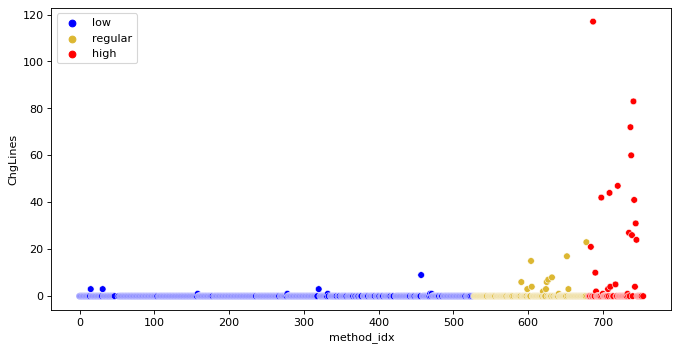

In [13]:
sub_df1 = df[['Method','CLevel_threshold', 'ChgLines']]
sub_df1 = sub_df1.sort_values(by=['CLevel_threshold'], key=lambda x: x.map(custom_dict), ignore_index=True)
sub_df1['method_idx'] = sub_df1.index

fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
sns.scatterplot(data=sub_df1, x="method_idx", y="ChgLines", hue="CLevel_threshold", 
                palette={'low':'blue', 'regular':'#DCB732', 'high':'red'})
plt.legend(loc='upper left')
plt.savefig(plots_save_to_location + '/chg-lines_threshold', bbox_inches = 'tight', pad_inches = 0)

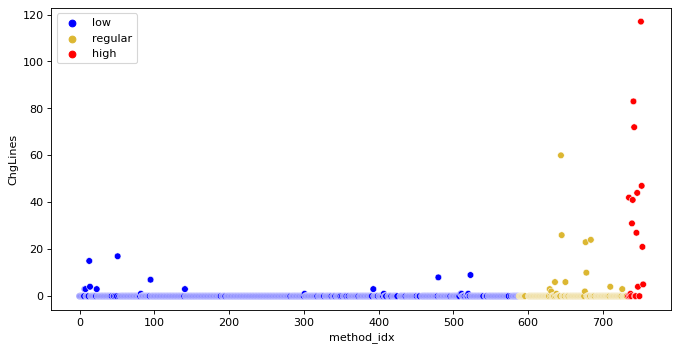

In [14]:
sub_df2 = df[['Method', 'CLevel_k_means', 'ChgLines']]
sub_df2 = sub_df2.sort_values(by=['CLevel_k_means'], key=lambda x: x.map(custom_dict), ignore_index=True)
sub_df2['method_idx'] = sub_df2.index

fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
sns.scatterplot(data=sub_df2, x="method_idx", y="ChgLines", hue="CLevel_k_means", 
                palette={'low':'blue', 'regular':'#DCB732', 'high':'red'})
plt.legend(loc='upper left')
plt.savefig(plots_save_to_location + '/chg-lines_k_means', bbox_inches = 'tight', pad_inches = 0)

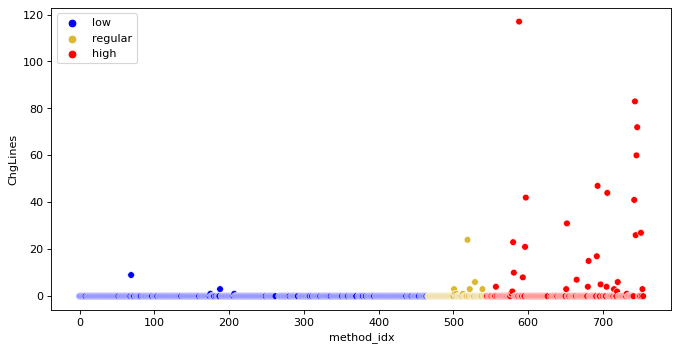

In [15]:
sub_df3 = df[['Method', 'CLevel_em', 'ChgLines']]
sub_df3 = sub_df3.sort_values(by=['CLevel_em'], key=lambda x: x.map(custom_dict), ignore_index=True)
sub_df3['method_idx'] = sub_df3.index

fig, ax = plt.subplots(figsize=(10,5), dpi= 80)
sns.scatterplot(data=sub_df3, x="method_idx", y="ChgLines", hue="CLevel_em", 
                palette={'low':'blue', 'regular':'#DCB732', 'high':'red'})
plt.legend(loc='upper left')
plt.savefig(plots_save_to_location + '/chg-lines_em', bbox_inches = 'tight', pad_inches = 0)